# Setup

📝 *Import required libraries and files:*

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import json, joblib

# -- 5.2. Analysis of the results
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
path = "../assets/df_sentiment.parquet"
df_sentiment = pd.read_parquet(path)
print(f"df shape: {df_sentiment.shape}")
df_sentiment.head(2)

df shape: (703563, 20)


,review_id,app,score,review_text,review_text_clean,review_date,year,thumbs_up,replied,reply_text,reply_text_clean,reply_date,time_to_reply(h),app_version_head,app_version_detail,review_sentiment,review_sentiment_label,Consistent,reply_sentiment,reply_sentiment_label
0,1,Santander,5,"very easy to use app, very happy with it","very easy to use app, very happy with it",2025-09-04 14:21:00,2025,0,1,"Hi! Thanks for the 5* review, we're so glad to...","hi! thanks for the 5* review, we're so glad to...",2025-09-04 14:40:12,0.32,5,24.0,0.8012,positive,1,0.8767,positive
1,2,Santander,3,New 2024 app is slow to open. Too much whitesp...,new 2024 app is slow to open. too much whitesp...,2025-09-04 13:36:26,2025,3,1,Hey there! All feedback is greatly appreciated...,hey there! all feedback is greatly appreciated...,2024-04-29 14:16:29,-11831.33,5,24.0,-0.9020,negative,1,0.8930,positive


## 5.1. - Model Deployment

In section 4.1., three LDA models were trained: i) lda_ALL trained on all type of reviews; 2) lda_NEG trained on negative reviews only; 3) lda_POS trained on positive reviews only. Now we will transform the original dataframe we had at the beggining of this notebook using the 3 selected LDAs and assigning the corresponding topic labels for each review and model. All the transformations are encapsulated inside `apply_ldas` to facilitate reproducibility.

In [3]:
def apply_ldas(
    df: pd.DataFrame,
    text_col: str = "review_text_clean",
    # generic model (trained on all reviews)
    lda_path: str = "../assets/lda_final_ALL.pkl",
    vect_path: str = "../assets/vectorizer_final_ALL.pkl",
    # negative-only model
    lda_neg_path: str = "../assets/lda_final_NEG.pkl",
    vect_neg_path: str = "../assets/vectorizer_final_NEG.pkl",
    # positive-only model
    lda_pos_path: str = "../assets/lda_final_POS.pkl",
    vect_pos_path: str = "../assets/vectorizer_final_POS.pkl",
    inplace: bool = True,
) -> pd.DataFrame:
    """
    Apply 3 LDA models on the dataframe:
      Generic: topic_id_ALL, topic_label_ALL, topic_prob_ALL
      Negative-only (score in {1,2}): topic_id_NEG, topic_label_NEG, topic_prob_NEG
      Positive-only (score in {4,5}): topic_id_POS, topic_label_POS, topic_prob_POS
    """
    if not inplace:
        df = df.copy()

    print(f"Initial shape of the dataframe: {df.shape}")

    # --- Text cleaning ----------------------------------------------------
    def text_cleaner(x):
        if not isinstance(x, str):
            return pd.NA
        t = x
        t = re.sub(r"@\w+", " ", t)                  # remove @mentions
        t = re.sub(r"\d+", " <num> ", t)             # numbers -> <num>
        t = re.sub(r"[^a-z\s<>]+", " ", t)           # keep letters, spaces, and <> so <num> survives
        t = re.sub(r"\s+", " ", t).strip()           # normalize whitespace
        return t if t else pd.NA

    df["review_extra_clean"] = df[text_col].map(text_cleaner)   

    if text_col not in df.columns:
        raise KeyError(f"Column '{text_col}' not found.")

    s = df[text_col].astype("string")  # NA-safe string Series

    # ----------------- helper -----------------
    def _apply_one(lda, vect, mask_rows, label_map, col_suffix, nan_outside_mask: bool):
        """
        lda, vect: fitted artifacts
        mask_rows: boolean mask of rows to consider for this model
        label_map: dict[int,str] mapping topic id -> label
        col_suffix: '_ALL', '_NEG', or '_POS'
        nan_outside_mask:
            - True  -> rows outside mask get NaN in all 3 columns (for neg/pos models)
            - False -> rows outside eligibility get Undefined/-1/0.0 (for generic model)
        """
        if not hasattr(vect, "transform"):
            raise TypeError("Loaded vectorizer has no .transform()")

        # Eligibility rules
        analyzer = vect.build_analyzer()
        
        sw_ok = s.fillna("").map(lambda t: len(analyzer(t)) >= 1)
        consistent_ok = df["Consistent"].fillna(0).astype(int).eq(1)

        elig = mask_rows & sw_ok & consistent_ok

        # Prepare outputs
        if nan_outside_mask:
            # For neg/pos models we keep NaN outside the score mask
            topic_id = pd.Series(np.nan, index=df.index, dtype="float")
            topic_prob = pd.Series(np.nan, index=df.index, dtype="float")
            topic_label = pd.Series(np.nan, index=df.index, dtype="string")
        else:
            # For generic model, fill with Undefined defaults when ineligible
            topic_id = pd.Series(-1, index=df.index, dtype="int64")
            topic_prob = pd.Series(0.0, index=df.index, dtype="float64")
            topic_label = pd.Series("Undefined", index=df.index, dtype="string")

        # Vectorize eligible subset
        if elig.any():
            X = vect.transform(s[elig].fillna(""))

            # Rule 3: drop zero-feature rows (OOV)
            zero = np.array(X.sum(axis=1)).ravel() == 0
            if zero.any():
                bad_idx = s[elig].index[zero]
                elig.loc[bad_idx] = False
                if elig.any():
                    X = vect.transform(s[elig].fillna(""))

            # Score eligible
            if elig.any():
                D = lda.transform(X)                       # (n_docs_elig, n_topics)
                ti = D.argmax(axis=1)
                tp = D.max(axis=1)

                topic_id.loc[elig] = ti
                topic_prob.loc[elig] = tp
                topic_label.loc[elig] = pd.Series(ti, index=df[elig].index).map(
                    lambda k: label_map.get(int(k), "Undefined")
                ).astype("string")

        # Attach to df
        df[f"topic_id{col_suffix}"] = topic_id
        df[f"topic_label{col_suffix}"] = topic_label
        df[f"topic_prob{col_suffix}"] = topic_prob

    # ----------------- load artifacts -----------------
    lda_all = joblib.load(lda_path)
    vect_all = joblib.load(vect_path)
    lda_neg = joblib.load(lda_neg_path)
    vect_neg = joblib.load(vect_neg_path)
    lda_pos = joblib.load(lda_pos_path)
    vect_pos = joblib.load(vect_pos_path)

    # ----------------- label maps (edit to your final names) -----------------
    labels_gen = {
        0: "Fees & Service & Travel",
        1: "Updates, Crashes & Performance",
        2: "Login, Navigation & Functionality Issues",
        3: "Money Transfers & Payment Management",
        4: "Support & Access",
        5: "Transactions, Features & Usability",
        6: "Cards & Payments",
    } 
    labels_neg = {
        0: "Login & Security",
        1: "Payments & Cards",
        2: "Updates & Crashes",
        3: "Transfers & Transact",
        4: "Interface & Fees",
        5: "Customer Support",
    }
    # Stub/default for positive model – adjust to your pos-only training labels
    labels_pos = {
        0: "Usability",
        1: "Features & Security",
        2: "Transactions & Money Mgmt",
        3: "Investments",
        4: "Cards & Travel",
        5: "Updates & Support",
    }

    # ----------------- run all three -----------------
    # Generic: run for everyone; ineligible -> Undefined/-1/0.0
    _apply_one(lda_all, vect_all, mask_rows=pd.Series(True, index=df.index), label_map=labels_gen,
               col_suffix="_ALL", nan_outside_mask=False)

    # Negative-only: only when score ∈ {1,2}; outside mask stays NaN
    _apply_one(lda_neg, vect_neg, mask_rows=df["score"].isin([1, 2]), label_map=labels_neg,
               col_suffix="_NEG", nan_outside_mask=True)

    # Positive-only: only when score ∈ {4,5}; outside mask stays NaN
    _apply_one(lda_pos, vect_pos, mask_rows=df["score"].isin([4, 5]), label_map=labels_pos,
               col_suffix="_POS", nan_outside_mask=True)

    # conditions
    cond_neg = df['score'].isin([1, 2])
    cond_pos = df['score'].isin([4, 5])
    
    # topic_label_SEG
    df['topic_label_SEG'] = np.select(
        [cond_neg, cond_pos],
        [df['topic_label_NEG'], df['topic_label_POS']],
        default= df['topic_label_ALL']
    )
    
    # topic_prob_SEG
    df['topic_prob_SEG'] = np.select(
        [cond_neg, cond_pos],
        [df['topic_prob_NEG'], df['topic_prob_POS']],
        default= df['topic_prob_ALL']
    )
    
    # Final cleaning droping unnecessary columns
    df = df.drop(columns=["year", "review_extra_clean", "review_text_clean","reply_text_clean", 
                          "topic_id_ALL", "topic_id_NEG", "topic_id_POS",])

    # Order columns: keep original order, then append all new columns
    tail = ["topic_label_ALL","topic_prob_ALL","topic_label_SEG","topic_prob_SEG",
            "topic_label_POS","topic_prob_POS","topic_label_NEG","topic_prob_NEG"]
    base = [c for c in df.columns if c not in tail]
    df = df[base + tail]

    print(f"Final shape of the dataframe: {df.shape}")

    # --- Save Final Dataframe ---
    save_path = "../assets/df_final.parquet"
    df.to_parquet(save_path, index = False)
    print(f"✅ Dataframe saved in {save_path}")

    return df

In [4]:
df_final = apply_ldas (df_sentiment)

Initial shape of the dataframe: (703563, 20)
Final shape of the dataframe: (703563, 25)
✅ Dataframe saved in ../assets/df_final.parquet


In [5]:
pd.set_option("display.max_columns", None)
df_final.head(5)

,review_id,app,score,review_text,review_date,thumbs_up,replied,reply_text,reply_date,time_to_reply(h),app_version_head,app_version_detail,review_sentiment,review_sentiment_label,Consistent,reply_sentiment,reply_sentiment_label,topic_label_ALL,topic_prob_ALL,topic_label_SEG,topic_prob_SEG,topic_label_POS,topic_prob_POS,topic_label_NEG,topic_prob_NEG
0,1,Santander,5,"very easy to use app, very happy with it",2025-09-04 14:21:00,0,1,"Hi! Thanks for the 5* review, we're so glad to...",2025-09-04 14:40:12,0.32,5,24.0,0.8012,positive,1,0.8767,positive,Undefined,0.000000,<NA>,NaN,<NA>,NaN,<NA>,NaN
1,2,Santander,3,New 2024 app is slow to open. Too much whitesp...,2025-09-04 13:36:26,3,1,Hey there! All feedback is greatly appreciated...,2024-04-29 14:16:29,-11831.33,5,24.0,-0.9020,negative,1,0.8930,positive,"Transactions, Features & Usability",0.601978,"Transactions, Features & Usability",0.601978,<NA>,NaN,<NA>,NaN
2,3,Santander,5,easy to use.. Great..,2025-09-04 13:27:27,0,1,"Hello Karen, thanks for the great feedback and...",2025-09-04 13:32:12,0.08,5,24.0,0.7906,positive,1,0.9100,positive,Undefined,0.000000,<NA>,NaN,<NA>,NaN,<NA>,NaN
3,4,Santander,2,having issues with your updates .. advice,2025-09-04 13:26:24,0,1,We would need a bit more information about the...,2025-09-04 13:36:37,0.17,5,22.0,0.0000,neutral,1,0.4588,positive,"Transactions, Features & Usability",0.713743,Payments & Cards,0.719216,<NA>,NaN,Payments & Cards,0.719216
4,5,Santander,5,so easy to use,2025-09-04 12:37:14,0,1,Many thanks for your 5 star review.\n^ES ^ES,2025-09-04 12:47:38,0.17,5,24.0,0.4927,positive,1,0.4404,positive,Undefined,0.000000,<NA>,NaN,<NA>,NaN,<NA>,NaN


## 5.2. - Analyse Results

### 5.2.1. - All reviews model

1️⃣ **Coherence sanity check** by evaluating a sample of reviews / labels

In [6]:
def get_sample_lda(
    df: pd.DataFrame,
    app: str | None = None,
    words: str | None = None,
    score: int | None = None,
    label_col: str | None = "topic_label_SEG",
    topics: str | None = None,
    prob_col: str | None = "topic_prob_SEG",     
    n: int = 5,
    seed: int | None = None,
    ):
    """
    Returns a random list of 'n' reviews filtered by the given parameters, prioritizing reviews with topic_prob_SEG >= 0.5.
    Parameters:
        df (pd.DataFrame): DataFrame with at least ['App', 'review_text', 'score', 'review_date', 'topic_label_SEG', 'topic_prob_SEG'].
        app (str, optional): Filter by app name.
        words (str, optional): Filter reviews containing these words (case-insensitive).
        score (int, optional): Filter reviews containing a given score.
        topics (str, optional): Filter by topic column containing this string.
        n (int, default=5): Number of samples to return.
    Returns: pd.Series: Randomly selected review texts.
    """
    
    filtered = df.copy()
    
    # --- Apply filters ----------------------------------------------------------
    if app:
        m = filtered['app'].astype(str).str.contains(app, case=False, na=False)
        filtered = filtered[m]
        
    if words:
        m = filtered['review_text'].astype(str).str.contains(words, case=False, na=False)
        filtered = filtered[m]

    if score is not None:
        m = filtered['score'].astype('Int64') == int(score)
        filtered = filtered[m]

    if topics:
        m = filtered[label_col].astype(str).str.contains(topics, case=False, na=False)
        filtered = filtered[m]
        
    # --- Prioritized sampling ---------------------------------------------------
    high = filtered.loc[filtered[prob_col] >= 0.5]
    low  = filtered.loc[filtered[prob_col]  < 0.5]

    rng = np.random.default_rng(seed)
    rs_high = int(rng.integers(0, 1_000_000_000)) if len(high) else None
    rs_low  = int(rng.integers(0, 1_000_000_000)) if len(low)  else None

    n_high = min(len(high), n)
    n_low  = max(0, n - n_high)

    take_high = high.sample(n=n_high, random_state=rs_high) if n_high > 0 else high.iloc[[]]
    take_low  = low.sample(n=n_low,   random_state=rs_low)  if n_low  > 0 else low.iloc[[]]

    out = pd.concat([take_high, take_low], ignore_index=True)
    
    # --- return only desired columns (if present) ---
    cols = ['app', 'review_text', 'score', 'review_date']
    cols.append(label_col)
    cols.append(prob_col)

    cols = [c for c in cols if c in out.columns]
    return out[cols]

In [7]:
samples_0 = get_sample_lda(df_final, label_col = 'topic_label_ALL', prob_col = "topic_prob_ALL", topics= "Fees & Service & Travel", n = 4, score = 1)
samples_1 = get_sample_lda(df_final, label_col = 'topic_label_ALL', prob_col = "topic_prob_ALL", topics= "Updates, Crashes & Performance", n = 4, score = 1)
samples_2 = get_sample_lda(df_final, label_col = 'topic_label_ALL', prob_col = "topic_prob_ALL", topics= "Login, Navigation & Functionality Issues", n = 4, score = 1)
samples_3 = get_sample_lda(df_final, label_col = 'topic_label_ALL', prob_col = "topic_prob_ALL", topics= "Money Transfers & Payment Management", n = 4, score = 1)
samples_4 = get_sample_lda(df_final, label_col = 'topic_label_ALL', prob_col = "topic_prob_ALL", topics= "Support & Access", n = 4, score = 1)
samples_5 = get_sample_lda(df_final, label_col = 'topic_label_ALL', prob_col = "topic_prob_ALL", topics= "Transactions, Features & Usability", n = 4, score = 1)
samples_6 = get_sample_lda(df_final, label_col = 'topic_label_ALL', prob_col = "topic_prob_ALL", topics= "Cards & Payments", n = 4, score = 1)

pd.set_option("display.max_colwidth", None)

display(samples_0)
print("----------")
display(samples_1)
print("----------")
display(samples_2)
print("----------")
display(samples_3)
print("----------")
display(samples_4)
print("----------")
display(samples_5)
print("----------")
display(samples_6)
print("----------")

,app,review_text,score,review_date,topic_label_ALL,topic_prob_ALL
0,Barclays,To many fees,1,2023-03-14 10:45:58,Fees & Service & Travel,0.571429
1,Santander,I just don't like the service you provide,1,2024-05-16 09:01:55,Fees & Service & Travel,0.526896
2,Revolut,Doesn't let you buy crypto from other platforms. Will give 5 stars when you change it.,1,2020-08-30 10:30:21,Fees & Service & Travel,0.828510
3,Revolut,"Ordered a Revolut card twice, it was never delivered. Can't trust a bank that charges me to deliver a card then never delivers it.",1,2019-04-06 17:13:58,Fees & Service & Travel,0.853831


----------


,app,review_text,score,review_date,topic_label_ALL,topic_prob_ALL
0,Santander,Loved this app but only works after i restart my phone sence last update then wont work again until restart i have uninstalled and tryd again,1,2020-06-10 18:35:38,"Updates, Crashes & Performance",0.892806
1,HSBC,"Rubbish, told in store to upgrade from old HSBC app to this new app. Can't login as stuck on migrating accounts screen.",1,2018-01-30 17:31:52,"Updates, Crashes & Performance",0.892713
2,HSBC,Started saying not connected to Internet when I was. Re-installed and worked for a day. Now crashes every time I open it. Useless.,1,2021-03-22 15:12:55,"Updates, Crashes & Performance",0.757374
3,Santander,App used to work brilliantly but now saying my phone is rooted (which it is not!) App is now useless!! Looking at the reviews below I have noticed the same issue has been a problem for many other users. Very annoying! I have also noticed that Santander has not commented or tried to fix the issue! Why not??,1,2020-06-17 23:23:41,"Updates, Crashes & Performance",0.952229


----------


,app,review_text,score,review_date,topic_label_ALL,topic_prob_ALL
0,Revolut,The ergonomy is even worse than before... i can't even find the feature to exchange devises anymore... definitely going to have a look at other actors before my next travel.,1,2020-06-03 20:38:20,"Login, Navigation & Functionality Issues",0.502457
1,Revolut,"Revolut es un buen banco virtual. Pero al tener algún tipo de problema con la app o el banco, el servicio al cliente no te ayuda a solucionar el problema. Copian y pegan respuestas ya redactadas, que no aportan a solucionar el problema. continuo sin poder acceder a mi cuenta hace un mes por la nueva actualización",1,2025-06-26 17:09:02,"Login, Navigation & Functionality Issues",0.845238
2,HSBC,"Nothing wrong with the previous version, so you're changed it? Soooooo slow and frustrating now!!",1,2022-01-22 18:35:53,"Login, Navigation & Functionality Issues",0.877122
3,HSBC,Can't even login...,1,2018-08-02 11:23:22,"Login, Navigation & Functionality Issues",0.571211


----------


,app,review_text,score,review_date,topic_label_ALL,topic_prob_ALL
0,Barclays,Why can't I transfer money from one to my another account in different bank??? And why I have to ring bank and pay for that?! Ridiculous!!!!,1,2018-01-06 15:59:36,Money Transfers & Payment Management,0.599526
1,Revolut,They closed my account without giving me reason and they are also not letting me withdraw my funds.,1,2021-08-08 19:50:52,Money Transfers & Payment Management,0.603236
2,Revolut,Why do I you need a selfie from me? Just because of that I will withdraw all my money from it and delete the app. Keep it simple!,1,2020-11-23 15:26:47,Money Transfers & Payment Management,0.528058
3,HSBC,"Pointless having a mobile app if the secure key is needed to access any accounts, every other banking app seems to have their act together except HSBC to the point where they lose their use as a bank.",1,2019-08-23 13:02:49,Money Transfers & Payment Management,0.588442


----------


,app,review_text,score,review_date,topic_label_ALL,topic_prob_ALL
0,Monzo,This is a great idea if you have the photographic prove of who you are . I tried to apply a while ago and because my passport was out of date and I dint drive I couldn't get an account with them . Such a pity because it would have made life easier for me and I would have been able to save money .,1,2022-01-06 14:09:55,Support & Access,0.523225
1,LLoyds,Lloyds are evil,1,2024-05-11 08:02:56,Support & Access,0.571370
2,Barclays,"very disappointed wanted a statement in February was still waiting middle of August i have since closed account and gone to different bank, app is a waste of time for everything.",1,2025-09-01 12:39:01,Support & Access,0.921914
3,Barclays,Shambles Shambles even their own fraud team's number is listed as potential fraud or spam when it comes up on your phone and if you check their number on a few Who Called Me Sites they actually are aware of it I got a call from their so called fraud team an Indian sounding female who couldn't even get my name right and she said Hello I'm from your bank (sound familiar think Fonejaker) she began demanding details including my card front and back details my full name address and date of birth,1,2024-03-27 20:19:33,Support & Access,0.758837


----------


,app,review_text,score,review_date,topic_label_ALL,topic_prob_ALL
0,LLoyds,"Can't for the life of me work out how to add our business account in the app, and branch staff can't help.",1,2019-07-22 15:50:27,"Transactions, Features & Usability",0.595095
1,Revolut,"Very bad UX. This app is mainly for selling finance products to user while basic functions are so hard to find. Less crypto, more banking please.",1,2021-11-22 14:03:34,"Transactions, Features & Usability",0.582604
2,HSBC,So much slower than previous version. May stop using as frustratingly slow. :(,1,2020-08-06 12:19:59,"Transactions, Features & Usability",0.509776
3,HSBC,Where has finger print recognition gone?,1,2019-10-30 12:15:15,"Transactions, Features & Usability",0.877310


----------


,app,review_text,score,review_date,topic_label_ALL,topic_prob_ALL
0,Revolut,"A plastic bank card for 5£. Thanks, I don't buy.",1,2019-07-20 00:19:35,Cards & Payments,0.857028
1,Revolut,Blocking users from buying,1,2021-02-02 18:41:26,Cards & Payments,0.785234
2,Revolut,"Terrible, won't accept my bank's debit card as a source of funds. Tried to close account but that option doesn't work. No way am I using such a shambolic app and place for my money.",1,2019-10-23 11:31:55,Cards & Payments,0.502456
3,Revolut,Not possible to verify credit card transfer via KBC Brussels app.,1,2021-04-12 19:33:18,Cards & Payments,0.521758


----------


2️⃣ **Topic distribution per type of sentiment**

In [8]:
topic_sent = (df_final.groupby(["topic_label_ALL","review_sentiment_label"], observed=True)
                        .size().unstack(fill_value=0))

topic_sent["total"] = topic_sent.get("negative", 0) + topic_sent.get("neutral", 0) + topic_sent.get("positive", 0)
topic_sent["share_neg"] = topic_sent.get("negative", 0) / topic_sent[["negative","neutral","positive"]].sum(axis=1).replace(0, np.nan)
topic_sent["share_pos"] = topic_sent.get("positive", 0) / topic_sent[["negative","neutral","positive"]].sum(axis=1).replace(0, np.nan)
topic_sent = topic_sent.sort_values(by="topic_label_ALL", ascending=True)

display(topic_sent)

review_sentiment_label,negative,neutral,positive,undefined,total,share_neg,share_pos
topic_label_ALL,,,,,,,
Cards & Payments,3125,3737,31927,0,38789,0.080564,0.823094
Fees & Service & Travel,3787,7974,58526,0,70287,0.053879,0.832672
"Login, Navigation & Functionality Issues",4338,6916,35143,0,46397,0.093497,0.757441
Money Transfers & Payment Management,2825,4398,44863,0,52086,0.054237,0.861326
Support & Access,17481,9114,30159,0,56754,0.308014,0.531399
"Transactions, Features & Usability",4287,6692,36750,0,47729,0.089820,0.769972
Undefined,22452,37719,285790,70,345961,0.064897,0.826076
"Updates, Crashes & Performance",13792,10323,21375,0,45490,0.303188,0.469883


3️⃣ **Topic distribution per app and scores**

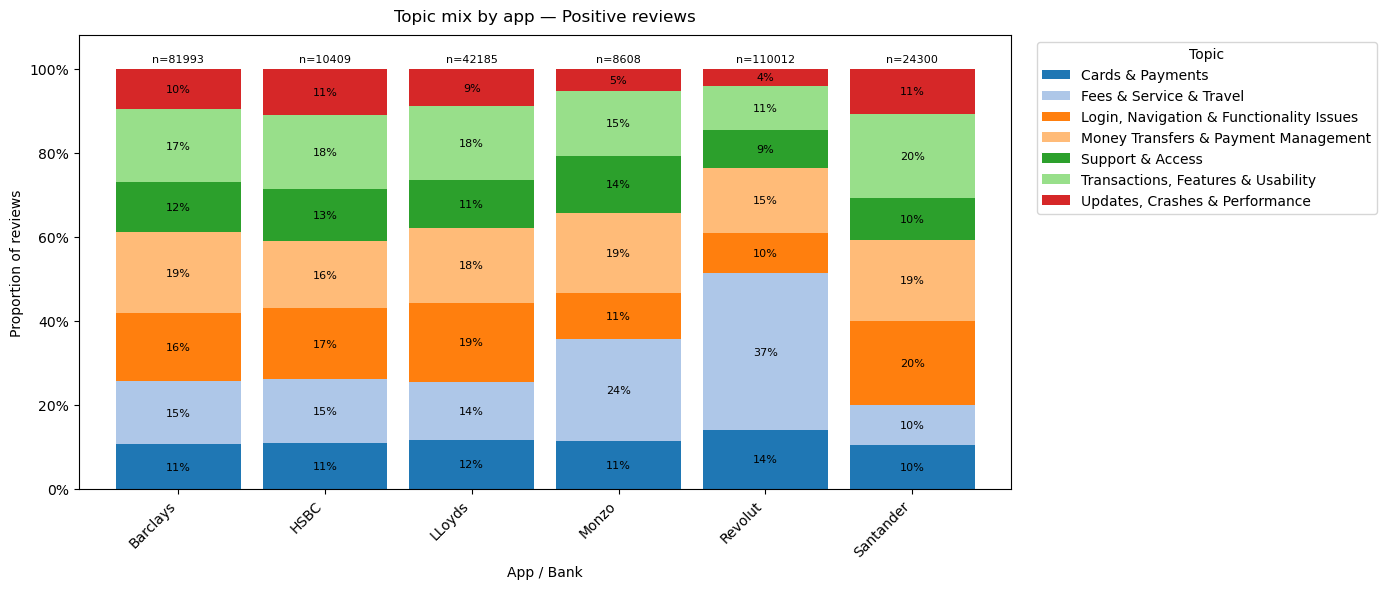

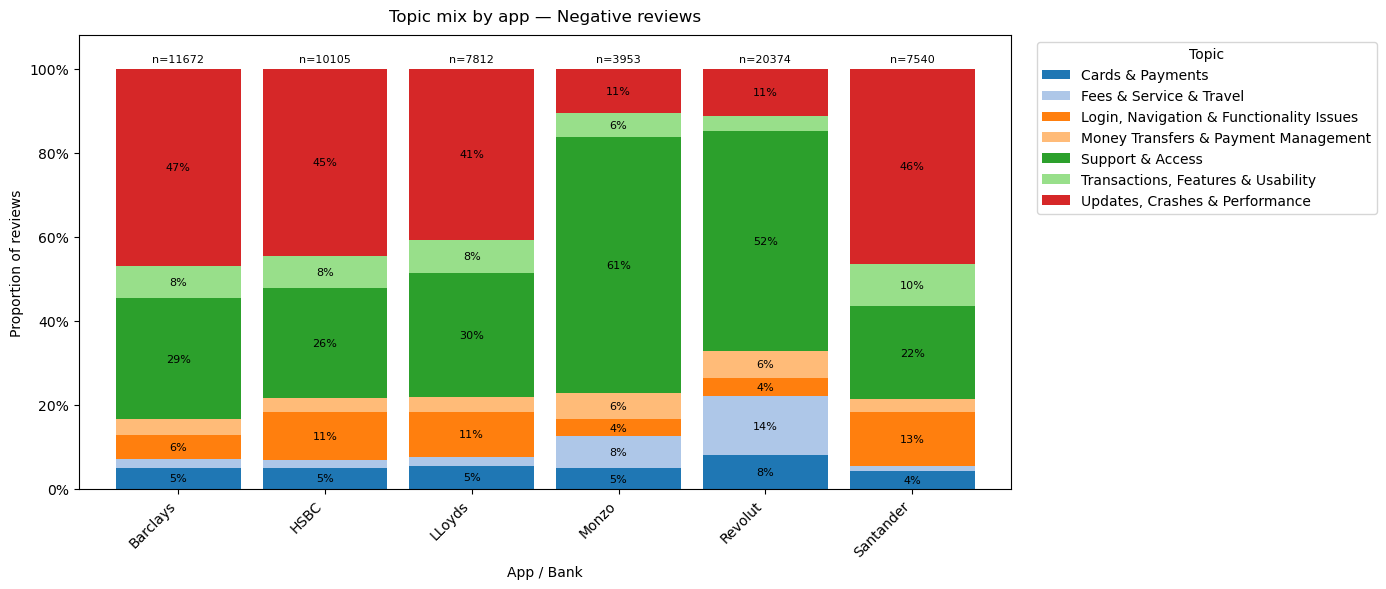

In [9]:
# Keep only rows where topic_label_ALL is not 'Undefined'
df_sub = df_final[df_final["topic_label_ALL"] != "Undefined"].copy()

# define topics, apps and colors
topics = sorted(df_sub['topic_label_ALL'].dropna().unique())
apps   = sorted(df_sub['app'].dropna().unique())

palette = plt.get_cmap('tab20').colors
topic_color = {t: palette[i % len(palette)] for i, t in enumerate(topics)}

def topic_share_by_app(df, score, label_col= 'topic_label_ALL', min_reviews=0):
    tmp = (df[df['score'].isin(score)]
             .dropna(subset=[label_col,'app'])
             .groupby(['app',label_col])
             .size()
             .unstack(fill_value=0))
    tmp = tmp.reindex(index=apps, columns=topics, fill_value=0)

    totals = tmp.sum(axis=1)
    if min_reviews > 0:
        tmp = tmp.loc[totals >= min_reviews]
        totals = tmp.sum(axis=1)

    shares = tmp.div(totals.replace(0, np.nan), axis=0).fillna(0)
    return shares, totals

def plot_stacked(shares, totals, title, label_threshold=0.04):
    ax = shares.plot(
        kind='bar', stacked=True, figsize=(14,6), width=0.85,
        color=[topic_color[t] for t in shares.columns]
    )
    ax.set_title(title)
    ax.set_xlabel('App / Bank')
    ax.set_ylabel('Proportion of reviews')
    ax.set_ylim(0, 1.08)
    ax.set_title(title, pad=10)  
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
    ax.legend(title='Topic', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # --- % labels inside segments ---
    for i, (_, row) in enumerate(shares.iterrows()):
        cum = 0.0
        for t in shares.columns:
            v = float(row[t])
            if v > 0:
                if v >= label_threshold:  # avoid clutter for tiny slices
                    ax.text(
                        i, cum + v/2, f"{v:.0%}",
                        ha='center', va='center',
                        fontsize=8,
                        color='black'
                    )
                cum += v

    # --- show n on top of each bar ---
    for i, n in enumerate(totals.loc[shares.index]):
        ax.text(i, 1.01, f"n={int(n)}", ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

# --- build data & plot ---
pos_shares, pos_totals = topic_share_by_app(df_sub, score = [4,5], label_col= 'topic_label_ALL', min_reviews=0)
neg_shares, neg_totals = topic_share_by_app(df_sub, score = [1,2], label_col= 'topic_label_ALL', min_reviews=0)

plot_stacked(pos_shares, pos_totals, "Topic mix by app — Positive reviews")
plot_stacked(neg_shares, neg_totals, "Topic mix by app — Negative reviews")

### 5.2.2. - Negative reviews model

1️⃣ **Coherence sanity check** by evaluating a sample of reviews / labels

In [10]:
# TO BE DONE

2️⃣ **Topic distribution per type of sentiment**

In [11]:
topic_sent = (df_final.groupby(["topic_label_NEG","score"])
                        .size().unstack(fill_value=0))
topic_sent['total'] = topic_sent[1]+topic_sent[2]
topic_sent.sort_values('topic_label_NEG', ascending=True)

score,1,2,total
topic_label_NEG,,,
Customer Support,9063,1884,10947
Interface & Fees,4702,2583,7285
Login & Security,10345,3595,13940
Payments & Cards,4409,3527,7936
Transfers & Transact,7328,1735,9063
Updates & Crashes,7417,3821,11238


3️⃣ **Topic distribution per app and scores**

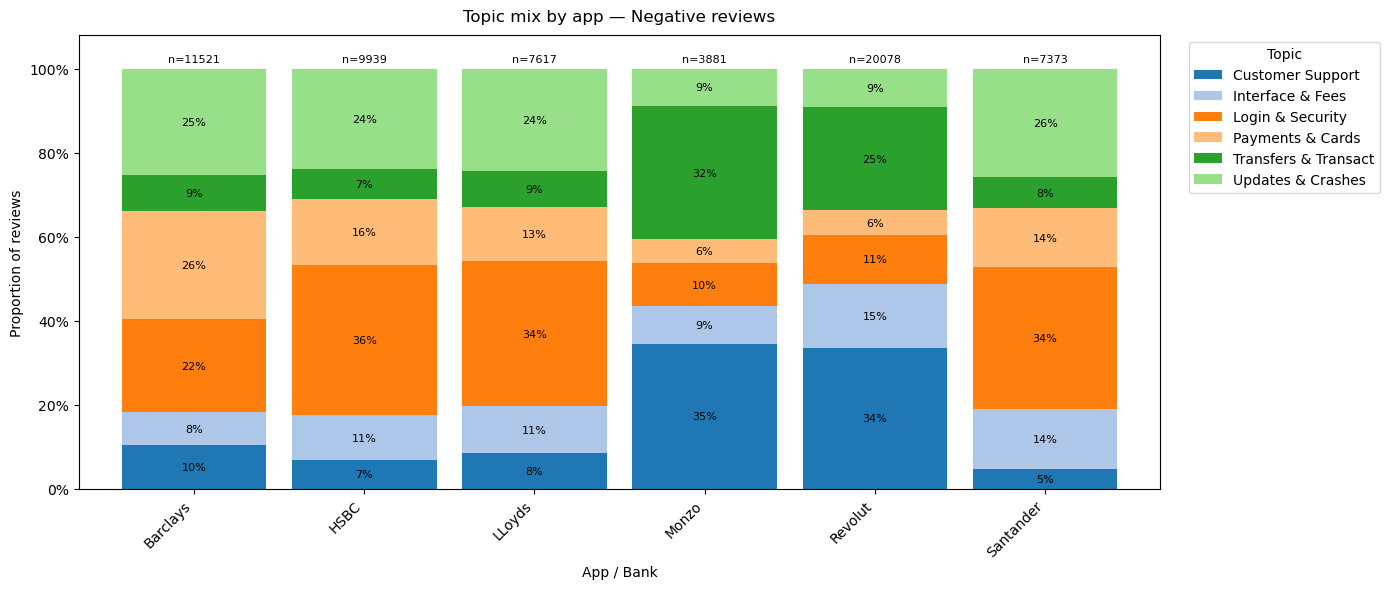

In [12]:
# Keep only rows where topic_label_ALL is not 'Undefined'
df_sub = df_final[df_final["topic_label_NEG"].notna()].copy()

# define topics, apps and colors
topics = sorted(df_sub['topic_label_NEG'].dropna().unique())
apps   = sorted(df_sub['app'].dropna().unique())

palette = plt.get_cmap('tab20').colors
topic_color = {t: palette[i % len(palette)] for i, t in enumerate(topics)}


# --- build data & plot ---
neg_shares, neg_totals = topic_share_by_app(df_sub, score = [1,2], label_col= 'topic_label_NEG', min_reviews=0)
plot_stacked(neg_shares, neg_totals, "Topic mix by app — Negative reviews")

### 5.2.3. - Positive reviews model

1️⃣ **Coherence sanity check** by evaluating a sample of reviews / labels

In [13]:
# to be done

2️⃣ **Topic distribution per type of sentiment**

In [14]:
topic_sent = (df_final.groupby(["topic_label_POS","score"])
                        .size().unstack(fill_value=0))
topic_sent['total'] = topic_sent[4]+topic_sent[5]
topic_sent.sort_values('topic_label_POS', ascending=True)

score,4,5,total
topic_label_POS,,,
Cards & Travel,5633,47696,53329
Features & Security,7776,38284,46060
Investments,5474,36995,42469
Transactions & Money Mgmt,4928,37551,42479
Updates & Support,11297,35027,46324
Usability,3088,39444,42532


3️⃣ **Topic distribution per app and scores**

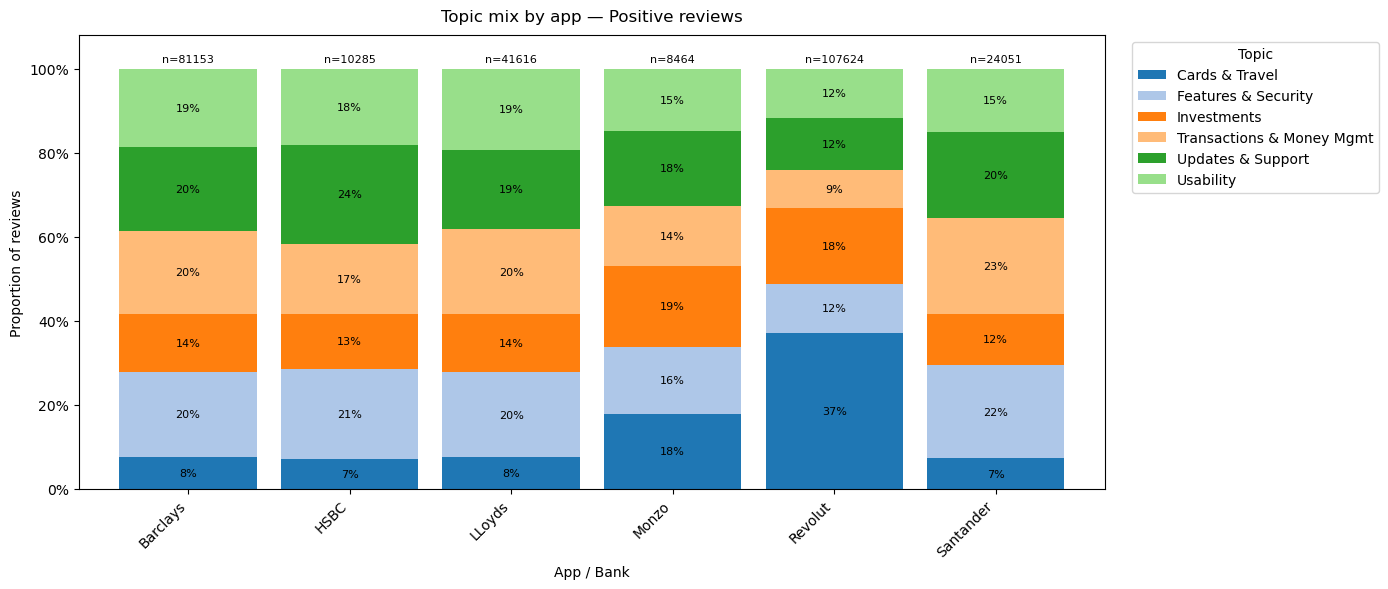

In [15]:
# Keep only rows where topic_label_ALL is not 'Undefined'
df_sub = df_final[df_final["topic_label_POS"].notna()].copy()

# define topics, apps and colors
topics = sorted(df_sub['topic_label_POS'].dropna().unique())
apps   = sorted(df_sub['app'].dropna().unique())

palette = plt.get_cmap('tab20').colors
topic_color = {t: palette[i % len(palette)] for i, t in enumerate(topics)}


# --- build data & plot ---
pos_shares, pos_totals = topic_share_by_app(df_sub, score = [4,5], label_col= 'topic_label_POS', min_reviews=0)
plot_stacked(pos_shares, pos_totals, "Topic mix by app — Positive reviews")

## 5.3. - Search reviews funcion - `get_sample`

In [16]:
def get_sample(
    df: pd.DataFrame,
    app: str | None = None,
    words: str | None = None,
    score: int | None = None,
    topics: str | None = None,
    n: int = 5,
    seed: int | None = None,
    ):

    filtered = df.copy()
    
    # --- Apply filters ----------------------------------------------------------
    if app:
        m = filtered['app'].astype(str).str.contains(app, case=False, na=False)
        filtered = filtered[m]

    if words:
        if isinstance(words, str):
            words = [words]  
    
        for w in words:
            pattern = r"\b" + re.escape(w) + r"\b"
            m = filtered['review_text'].astype(str).str.contains(
                pattern, case=False, na=False, regex=True
            )
            filtered = filtered[m]

    if score is not None:
        m = filtered['score'].astype('Int64') == int(score)
        filtered = filtered[m]

    if topics:
        m = filtered['topic_label_SEG'].astype(str).str.contains(topics, case=False, na=False)
        filtered = filtered[m]
        
    # --- Prioritized sampling ---------------------------------------------------
    high = filtered[filtered['topic_prob_SEG'] >= 0.5]
    low  = filtered[filtered['topic_prob_SEG'] < 0.5]
    
    rng = np.random.default_rng(seed)
    n_high = min(len(high), n)
    n_low = max(0, n - n_high)
    
    # createa a int random_state from the Generator
    rs_high = int(rng.integers(0, 1_000_000_000)) if len(high) else None
    rs_low  = int(rng.integers(0, 1_000_000_000)) if len(low)  else None

    n_high = min(len(high), n)
    n_low  = max(0, n - n_high)
    
    take_high = high.sample(n=n_high, random_state=rs_high) if n_high > 0 else high.iloc[[]]
    take_low  = low.sample(n=n_low,  random_state=rs_low)  if n_low  > 0 else low.iloc[[]]

    out = pd.concat([take_high, take_low], ignore_index=True)

    # --- Return only requested columns (if you want) ---
    cols = ['app', 'review_text', 'score', 'review_date', 'topic_label_SEG']
    cols = [c for c in cols if c in out.columns]
    return out[cols]

In [17]:
get_sample (df_final, app = 'Santander', words = 'speed')

,app,review_text,score,review_date,topic_label_SEG
0,Santander,easy to follow for the likes of myself who are not up to speed with all electronic gadgets.,5,2024-05-23 09:04:01,Investments
1,Santander,Increased functionality and now since latest update the speed of loading payees improved greatly.,5,2020-03-08 16:28:03,Updates & Support
2,Santander,The App is functional. My only issue is that it is slow to open and authenticate compared to my other banking apps. Please do send work to speed this up.,3,2018-12-02 13:39:56,"Login, Navigation & Functionality Issues"
3,Santander,"It's a very solid banking app, does everything I need it to (paying others, viewing my transactions, etc) the only real problem for me is the speed of which my transactions get updated, it sometimes takes a few days which is quite inconvenient but not too much of a problem for me personally",4,2019-08-28 11:49:13,Features & Security
4,Santander,simple and easy to use. fast speed . Layout is excellent.,5,2024-08-13 11:45:20,Updates & Support


## 5.4. - Streamlit dataframes

`df_tab1`

In [18]:
selected = df_final[['review_date','app','score']].copy()
selected['review_date'] = pd.to_datetime(selected['review_date'])
selected['app'] = selected['app'].astype('category')

selected['period_month'] = selected['review_date'].dt.to_period('M').dt.to_timestamp('M')

df_tab1 = (selected
    .groupby(['period_month','app'], observed=True)['score']
    .agg(avg_score='mean', n_reviews='size')
    .reset_index()
)

In [19]:
save_path = "../assets/df_tab1.parquet"
df_tab1.to_parquet(save_path, index = False)
print(f"✅ Dataframe saved in {save_path}")

✅ Dataframe saved in ../assets/df_tab1.parquet


`df_tab3`

In [21]:
df_tab3 = df_final[['review_id','app','score','review_text','review_date','topic_label_SEG','topic_prob_SEG','topic_label_ALL']]
save_path = "../assets/df_tab3.parquet"
df_tab2.to_parquet(save_path, index = False)
print(f"✅ Dataframe saved in {save_path}")

✅ Dataframe saved in ../assets/df_tab3.parquet
